In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [2]:
import os
import pathlib
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
from rasterio import features
from rasterio.features import shapes
import shapely
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, WGS84, UTM35N
from src.data_loading.rasterio_utils import polygonize
from src.data_loading.vector_utils import shapely_to_frame
from src.data_loading.landcover_plot_utils import plot_landcover
from src.utils import get_byte_size

from src.models.geograph import GeoGraph

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
# For speed tests:
gpd.options.use_pygeos

True

# Planning 

Next steps are:  

    1. Set sample cases of Chernobyl where we can tets the node identification
    2. Draft node identificaiton algorithm
    3. Test node identification algorithm
    
Information we can use in node identification algorithm:
- geospatial location
- overlap
- class value

Things to think about:
- What, if anything, should we put into edges?

## 1. Investigation of sample cases in Chernobyl region

In [6]:
# Parse geotif landcover data
esa_cci_landcovers = {year: GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.tif"  
                      for year in range(1992, 2016)}
    
# Parse land cover classes:
landcover_classes = ESA_LANDCOVER_DIR / "ESACCI-LC-Legend.csv"
classes = pd.read_csv(landcover_classes, delimiter=";", index_col=0)

# Parse ROIS
rois = gpd.read_file(GWS_DATA_DIR / "chernobyl_exclusion_zone_v1.geojson")

In [7]:
cez = rois[rois["name"] == "Chernobyl Exclusion Zone"]

In [8]:
data = {year: rxr.open_rasterio(path) for year, path in tqdm(esa_cci_landcovers.items())}

  0%|          | 0/24 [00:00<?, ?it/s]

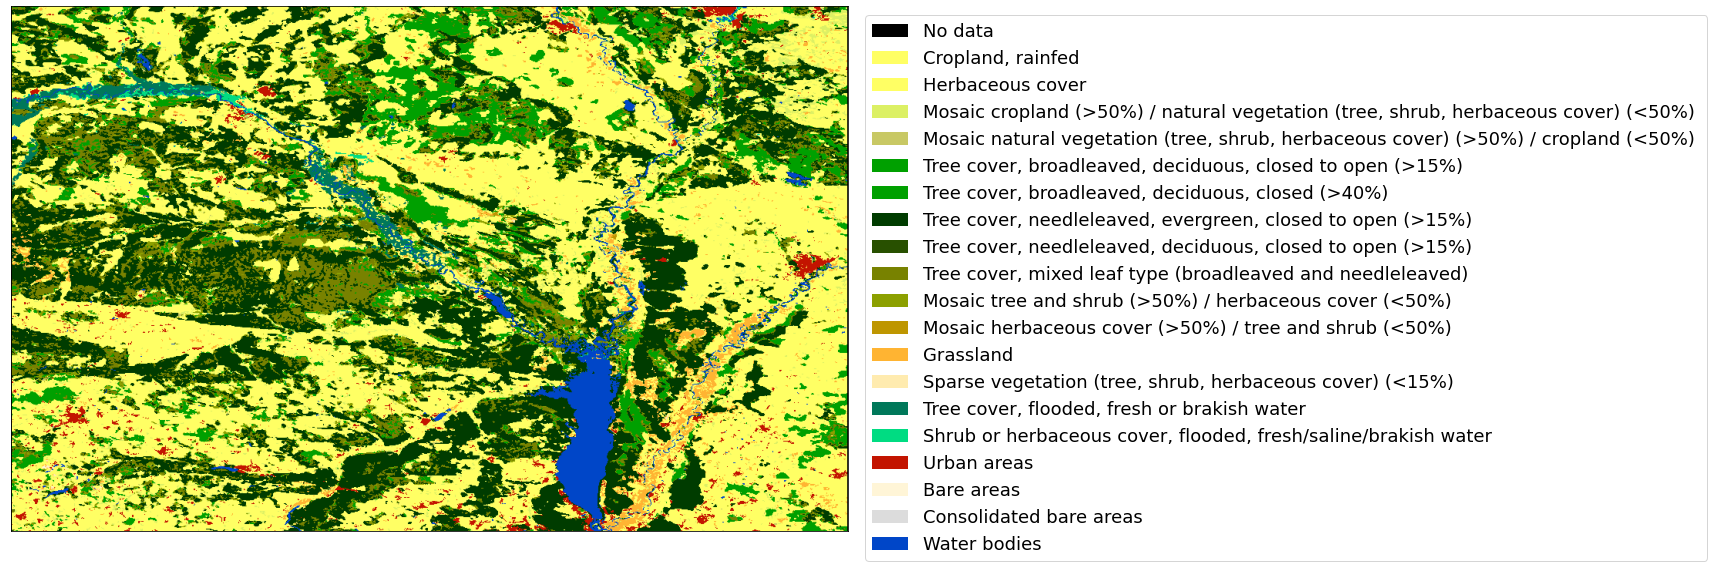

In [9]:
plot_landcover(data[2015].data, with_legend=True)

What do I want to know?
- How does the data look like on the ground? 
- How quickly do classes vary (a) spatially and (b) over time?
- How many "touchpoints" does one node have on average?

# 2. Helper functions

In [10]:
def clip_and_reproject(xrdata, clip_geometry=None, to_crs=UTM35N, x_res=300, y_res=300):
    
    if clip_geometry is not None:
        clipped_data = xrdata.rio.clip(clip_geometry)
    else:
        clipped_data = xrdata
        
    if to_crs is not None:
        reprojected_data = clipped_data.rio.reproject(to_crs, resolution=(x_res, y_res))
    else:
        reprojected_data = clipped_data
    
    return reprojected_data

In [11]:
import affine

# Mirror the x axis
affine_mirror_x = affine.Affine(-1, 0, 0, 
                                 0, 1, 0)
# Mirror the y axis
affine_mirror_y = affine.Affine(1,  0, 0, 
                                0, -1, 0)
# Make sure array is plotted as in imshow
def get_array_transform(arr):
    
    return affine.Affine.translation(0, arr.shape[0]) * affine_mirror_y 
    

In [12]:
def plot_poly_distribution(geodataframe):
    
    areas_in_hectar = geodataframe.area / 1e4
    
    sns.histplot(np.log10(areas_in_hectar))
    plt.xlabel("Area [ha]")
    plt.title("Polygon size distribution")
    plt.text(x=4, 
             y=600, 
             s=str((areas_in_hectar).describe().apply("{0:.0f}".format))[:-14],
             bbox=dict(facecolor='w', alpha=0.5)
            )

    plt.xticks(ticks=range(1,6), labels=[f"$10^{i}$" for i in range(1,6)]);

# 3. Analysing ESA CCI Landcover polys as test

## 3.1 Create polys

In [13]:
cez_raster = {}
cez_poly = {}

# Processing the data
for year, xrdata in tqdm(data.items()):
    #Clipping and reprojecting raster data
    cez_raster[year] = clip_and_reproject(xrdata, 
                                  clip_geometry=cez.geometry, 
                                  to_crs=UTM35N, 
                                  x_res=300, 
                                  y_res=300)
    # Polygonizing
    cez_poly[year] = polygonize(cez_raster[year].data, 
                                transform=cez_raster[year].rio.transform(),
                                crs=UTM35N)

  0%|          | 0/24 [00:00<?, ?it/s]

## 3.2 Plot region

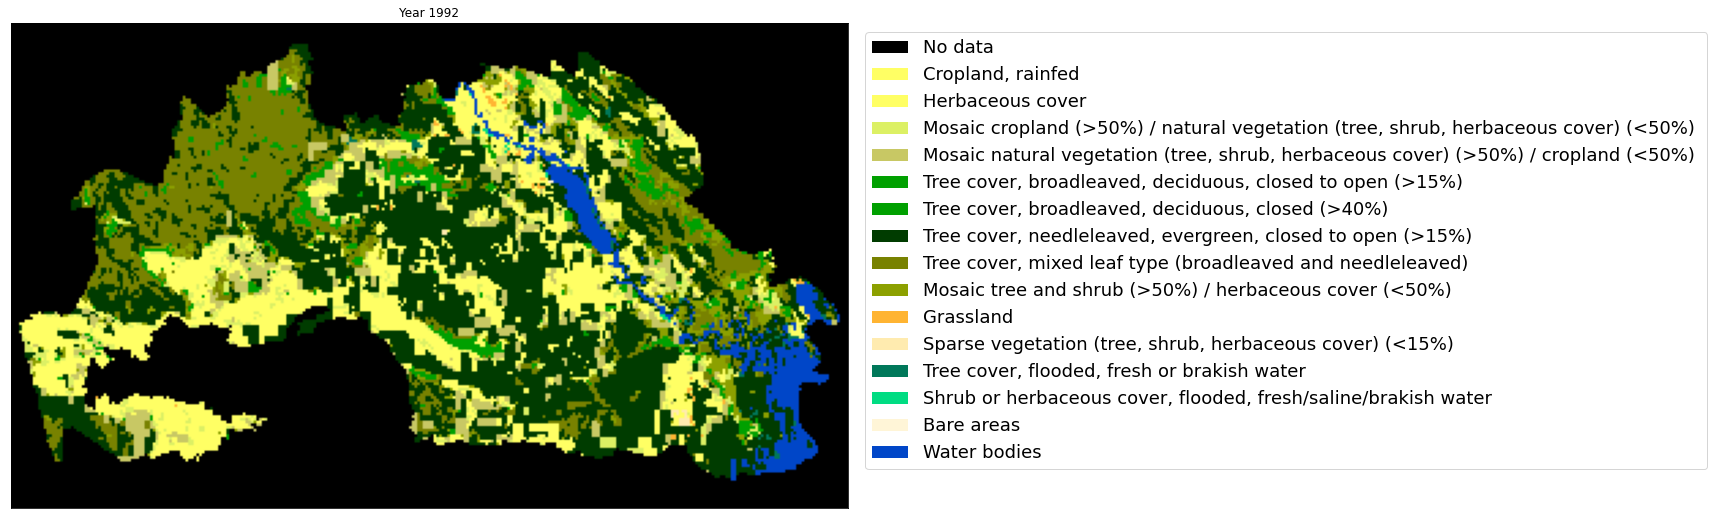

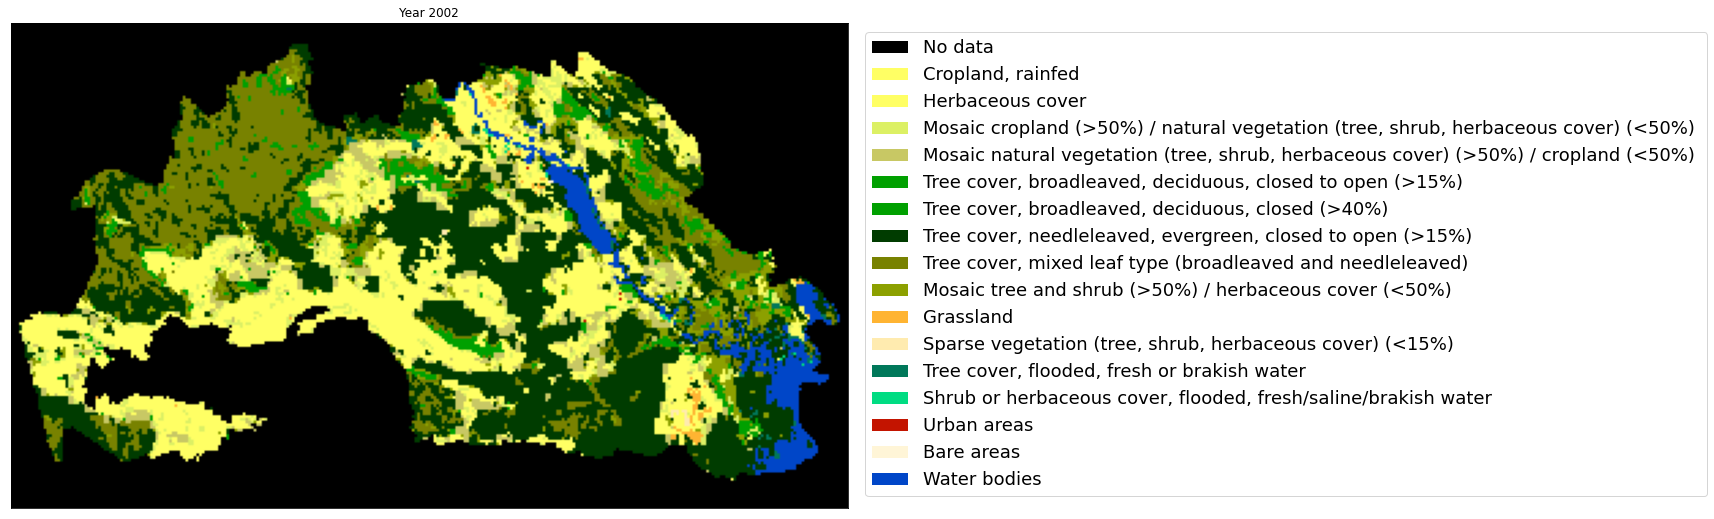

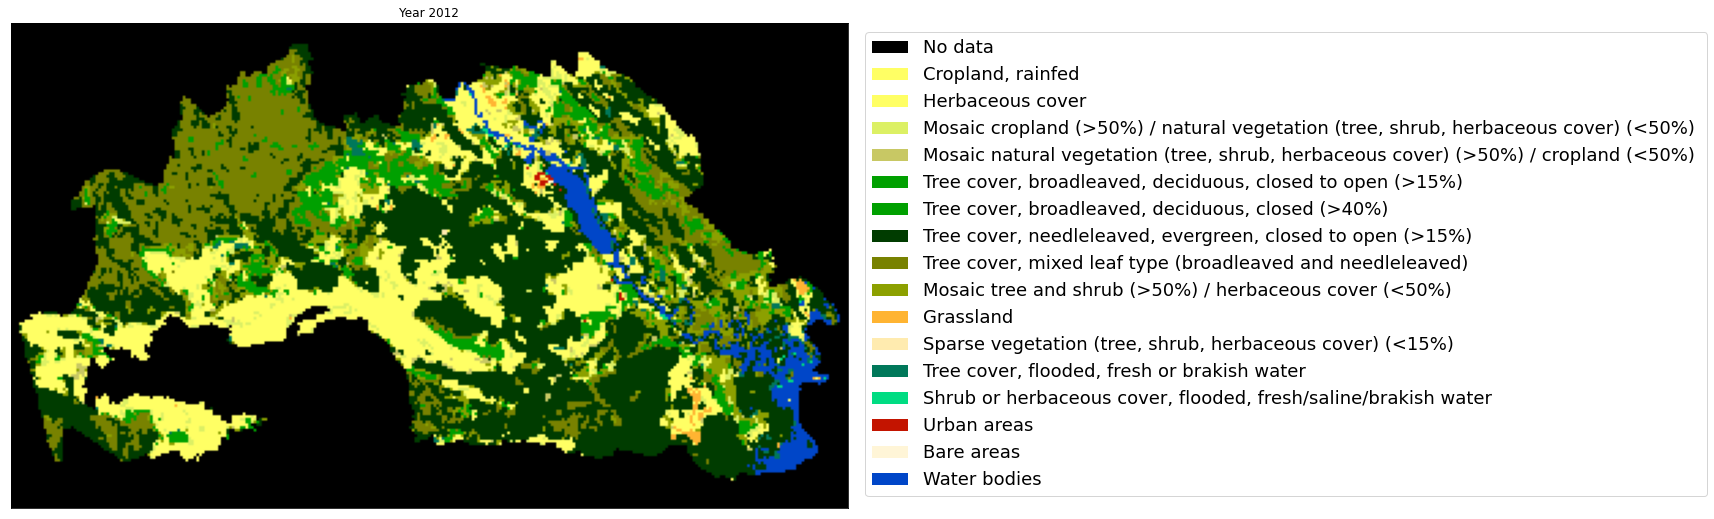

In [23]:
# Plotting
for year in range(1992, 2016, 10):
    plot_landcover(cez_raster[year].data)
    plt.title(f"Year {year}")
    plt.show()

## 3.3 Plot poly characteristics

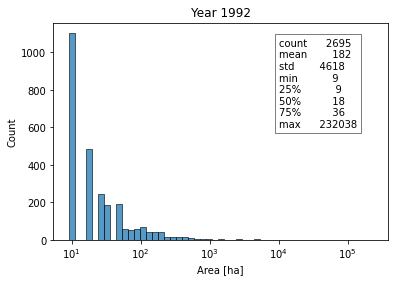

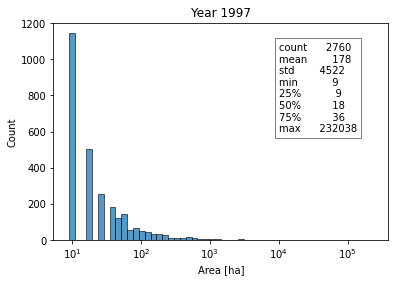

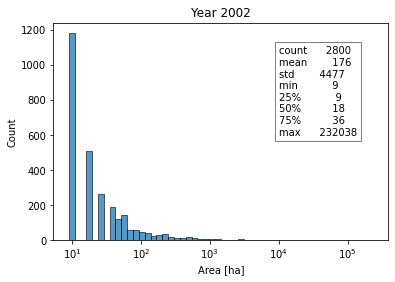

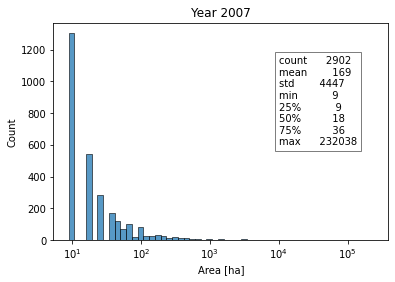

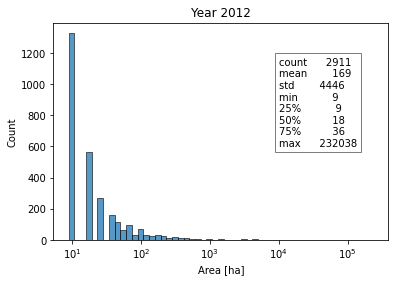

In [24]:
# Plotting
for year in range(1992, 2016, 5):
    plot_poly_distribution(cez_poly[year])
    plt.title(f"Year {year}")
    plt.show()

# 4. Creating a graph from CEZ polys

In [14]:
from src.models.geograph import GeoGraph

In [21]:
%%time
gpd.options.use_pygeos = True
graph_2015 = GeoGraph(cez_poly[2015])

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 2918/2918 [00:09<00:00, 295.18it/s]
Step 2 of 2: Adding edges: 100%|██████████| 2918/2918 [00:00<00:00, 53057.93it/s]

CPU times: user 8.43 s, sys: 148 ms, total: 8.58 s
Wall time: 10.2 s


In [22]:
graph_2015.graph.number_of_edges()

8511

In [23]:
graph_2015.graph.number_of_nodes()

2918

Average number of neighbors is about 3.

In [24]:
graph_2015

GeoGraph:
	Id: 0x7f4db5bf2670
	Nodes: 2918
	Edges: 8511

# 5. Create test poly geometries

In [25]:
def inspect_geoframe(arr_polys):
    import ipywidgets
    @ipywidgets.interact(index=ipywidgets.IntSlider(value=0, min=0, max=len(arr_polys)-1, step=1))
    def inspect_arr_polys(index:int=0):
        if "class_label" in arr_polys.columns:
            print(f"Class label: \t{arr_polys.iloc[index].class_label}")
        print(f"Area:         \t{arr_polys.iloc[index].geometry.area:.0f}")
        return arr_polys.iloc[index].geometry

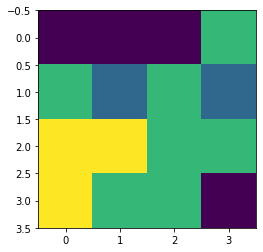

In [26]:
arr = np.random.randint(low=1, high=5, size=(4,4), dtype=np.uint8)
plt.imshow(arr)

In [137]:
arr_polys = polygonize(arr, transform=get_array_transform(arr))

In [138]:
# NOte: GDAL polygonize indexes with (1) Leftmost (2) top pixel of a polygon
inspect_geoframe(arr_polys)

interactive(children=(IntSlider(value=0, description='index', max=10), Output()), _dom_classes=('widget-intera…

In [139]:
inspect_geoframe(cez_poly[2015])

interactive(children=(IntSlider(value=0, description='index', max=2917), Output()), _dom_classes=('widget-inte…

Note: We can fix the intersecting polygons which result in invalid geometries by adding
    `.buffer(0)`

In [178]:
inspect_geoframe(shapely_to_frame(cez_poly[2015].buffer(0)))

interactive(children=(IntSlider(value=0, description='index', max=2917), Output()), _dom_classes=('widget-inte…

In [183]:
np.prod(cez_raster[2015].shape)

54646

Size wise, we get about 3000 polygons from about 55'000 raster pixels, that means a compression in list
size to about 5%. However, the data size is not compressed (in fact increased) because we store the shapes
as complex shapes with polygon coorindates at eacht of the pixel edges. 

The hope is, however, that the polygon approach gives us an edge in terms of fast computations of certain metrics and analyses.

# 7. Find out what it means for shapely polygons to touch and intersect

In [23]:
import networkx as nx

<AxesSubplot:>

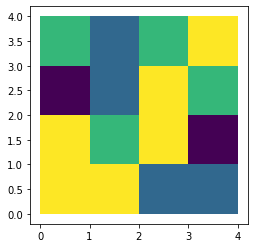

In [20]:
arr_polys.plot("raster_val")

In [21]:
arr_poly_graph = GeoGraph(dataframe=arr_polys)

Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 11/11 [00:00<00:00, 1030.89it/s]
Step 2 of 2: Adding edges: 100%|██████████| 11/11 [00:00<00:00, 11417.31it/s]


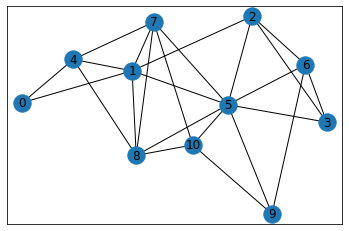

In [24]:
nx.draw_networkx(arr_poly_graph.graph)

In [191]:
arr_polys.iloc[0].geometry.touches(arr_polys.iloc[1].geometry)

True

Note: The shapely touches can have machine precision [errors](https://github.com/Toblerity/Shapely/issues/346) in case the polygon points are slightly displaced from each other by machine precision.

To get around this, one could use a `buffer-intersection` or a `shortest-distance-tolerance`
based method. Let's briefly check both and look at
- speed
- correctness
- ease of use

In [27]:
shape1 = arr_polys.iloc[0].geometry
shape2 = arr_polys.iloc[1].geometry
shape3 = arr_polys.iloc[2].geometry

In [53]:
%%time
shape1.touches(shape2)

CPU times: user 212 µs, sys: 57 µs, total: 269 µs
Wall time: 177 µs


True

In [54]:
%%time
shape1.touches(shape3)

CPU times: user 73 µs, sys: 20 µs, total: 93 µs
Wall time: 92.3 µs


False

In [55]:
%%time
shape1.intersects(shape2)

CPU times: user 58 µs, sys: 16 µs, total: 74 µs
Wall time: 85.8 µs


True

In [56]:
%%time
shape1.buffer(0.1).touches(shape2)

CPU times: user 688 µs, sys: 188 µs, total: 876 µs
Wall time: 662 µs


False

In [57]:
%%time
shape1.buffer(0.1).intersects(shape2)

CPU times: user 390 µs, sys: 635 µs, total: 1.02 ms
Wall time: 1.05 ms


True

# 8. Implement method to see whether nodes in two graphs are actually the same

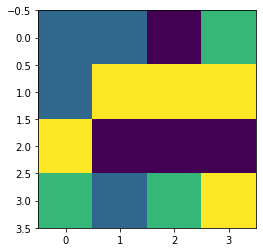

In [28]:
arr1 = np.random.randint(low=1, high=5, size=(4,4), dtype=np.uint8)
plt.imshow(arr1)

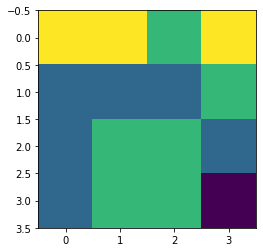

In [29]:
arr2 = np.random.randint(low=1, high=5, size=(4,4), dtype=np.uint8)
plt.imshow(arr2)

# 9. Generate test cases

In [42]:
np.random.seed(28)
arr1 = np.random.randint(low=1, high=5, size=(4,4), dtype=np.uint8)
plt.imshow(arr1)

TypeError: 'int' object is not callable

# X. Misc and scratchpad

In [133]:
from shapely.ops import unary_union
cu = unary_union(cez.geometry)
cez_poly = cez.geometry.values.unary_union()

In [148]:
%%timeit  # Seems slowest (3.3s in 7 runs)
poly_generator = rasterio.features.shapes(xrdata.data, transform=xrdata.rio.transform(), connectivity=4)
l = [shapely.geometry.shape(x[0]) for x in poly_generator]

3.3 s ± 440 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [149]:
%%timeit  # (2.8s in 7 runs)
results = (
    {'properties': {'raster_val': val}, 'geometry': shape}
    for shape, val in shapes(xrdata.data, 
                             mask=None, 
                             transform=xrdata.rio.transform())
                              
)
list(results);
print("done")

done
done
done
done
done
done
done
done
2.79 s ± 585 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [150]:
%%timeit  # Seems fastest (2.6s in 7 runs)
poly_generator = shapes(xrdata.data, mask=None, transform=xrdata.rio.transform())
results = list({'properties': {'raster_val': val}, 'geometry': shape}
                    for shape, val in poly_generator)
print("done")

done
done
done
done
done
done
done
done
2.59 s ± 455 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%time
polys2 = polygonize(xrdata_utm35.data)  # Extraction of polys for region is fairly quick

In [ ]:
%%time
polys = polygonize(xrdata_utm35.data)  # Extraction of polys for region is fairly quick

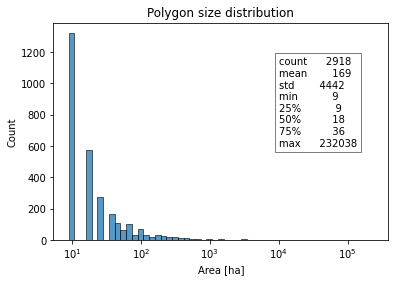

In [310]:
plot_poly_distribution(polys)

<AxesSubplot:>

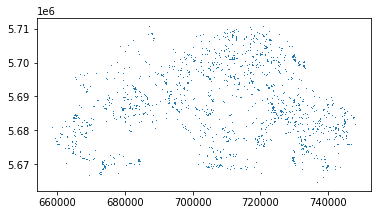

In [313]:
#One pixel polys:
polys[polys.area <= 9e4].plot()

<AxesSubplot:>

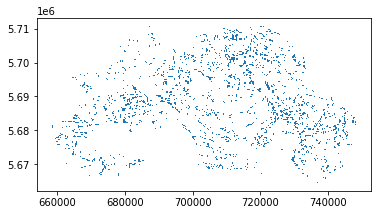

In [329]:
# One and two pixel polys
polys[polys.area <= 2*9e4].plot()

<AxesSubplot:>

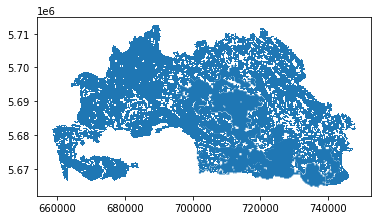

In [328]:
# One and two pixel polys
polys[polys.area.between(5*9e4, 10000*9e4)].plot()

<AxesSubplot:>

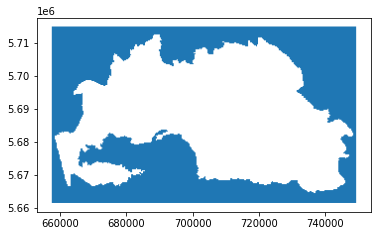

In [325]:
# One and two pixel polys
polys[polys.area.between(10000*9e4, 30000*9e4)].plot()

In [10]:
np.random.randint(low=1, high=5, size=(4,4))

array([[4, 4, 4, 1],
       [4, 2, 4, 1],
       [4, 2, 2, 3],
       [3, 3, 2, 4]])